In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

import PIL
import matplotlib.pyplot as plt
import numpy as np
import time
import cv2
import os

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = datasets.STL10(root='../../datasets/STL10', split='train', download=True, transform=transform)
train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded and verified


In [4]:
testset = datasets.STL10(root='../../datasets/STL10', split='test', download=True, transform=transform)
test_loader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified


In [23]:
classes =  ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

In [28]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2 ,0)))


dataiter = iter(test_loader)
images1, labels1 = dataiter.next()

imshow(torchvision.utils.make_grid(images[10]))
print(images.shape)

TypeError: can't convert CUDA tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            # 3 x 96 x 96
            nn.Conv2d(3, 10, 3, 1, 1),
            nn.Conv2d(10, 32, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            # 32 x 48 x 48
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            # 64 x 24 x 24
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            
            # 128 x 12 x 12
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2)
        )
        
        # 256 x 6 x 6
        self.avg_pool = nn.AvgPool2d(6)
        
        # 256 x 1 x 1
        self.fc = nn.Linear(256, 10)
        
    def forward(self, x):
        features = self.conv(x)
        flatten = self.avg_pool(features).view(features.size(0), -1)
        output = self.fc(flatten)
        
        return output, features
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
param = list(model.parameters())
print(len(param))
for i in param:
    print(i.shape)

12
torch.Size([10, 3, 3, 3])
torch.Size([10])
torch.Size([32, 10, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([10, 256])
torch.Size([10])


In [8]:
start = time.time()
print('\n ==> Training Start')

for epoch in range(100):
    total_loss =  0.0
    
    for data, target in train_loader:
        train_x, train_y = data.to(device), target.to(device)
        optimizer.zero_grad()
        outputs, f = model(train_x)
        loss = criterion(outputs, train_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print('\n epoch %d \t %.4f' % (epoch, total_loss))
end = time.time()

print('Elapsed Time : %.3f' % (end-start))


 ==> Training Start

 epoch 0 	 157.2922

 epoch 1 	 133.5384

 epoch 2 	 128.2282

 epoch 3 	 122.6712

 epoch 4 	 116.8950

 epoch 5 	 112.5256

 epoch 6 	 106.6613

 epoch 7 	 102.9259

 epoch 8 	 99.9792

 epoch 9 	 95.1029

 epoch 10 	 91.0655

 epoch 11 	 87.3993

 epoch 12 	 84.7279

 epoch 13 	 82.1118

 epoch 14 	 79.1378

 epoch 15 	 74.5912

 epoch 16 	 71.7078

 epoch 17 	 71.1405

 epoch 18 	 66.8042

 epoch 19 	 64.8199

 epoch 20 	 60.6706

 epoch 21 	 60.8093

 epoch 22 	 59.0815

 epoch 23 	 52.5288

 epoch 24 	 52.3742

 epoch 25 	 45.5841

 epoch 26 	 47.4585

 epoch 27 	 41.6434

 epoch 28 	 38.0615

 epoch 29 	 36.0547

 epoch 30 	 37.1424

 epoch 31 	 31.3271

 epoch 32 	 29.1216

 epoch 33 	 29.3235

 epoch 34 	 24.9746

 epoch 35 	 20.8975

 epoch 36 	 19.7860

 epoch 37 	 15.4554

 epoch 38 	 16.6708

 epoch 39 	 14.6558

 epoch 40 	 17.2695

 epoch 41 	 13.8707

 epoch 42 	 6.8802

 epoch 43 	 6.7033

 epoch 44 	 17.0713

 epoch 45 	 5.7504

 epoch 46 	 6.095

In [9]:
correct = 0
total = 0

for data, target in test_loader:
    test_x, test_y = data.cuda(), target.cuda()
    outputs, _ = model(test_x)
    _, predicted = torch.max(outputs, 1)
    
    total += test_y.size(0)
    correct += (predicted.cpu() == test_y.cpu()).sum().item()

print('Acc : %.3f' % ((correct/total) * 100))

Acc : 69.600


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.cuda()
        labels = labels.cuda()
        outputs, f = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(64):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplance : 82 %
Accuracy of  bird : 65 %
Accuracy of   car : 79 %
Accuracy of   cat : 58 %
Accuracy of  deer : 64 %
Accuracy of   dog : 55 %
Accuracy of horse : 71 %
Accuracy of monkey : 63 %
Accuracy of  ship : 81 %
Accuracy of truck : 75 %


In [14]:
torch.save(model, 'cam_stl10.pt')

In [33]:
params = list(model.parameters())

Predict : car 	 Ans : car


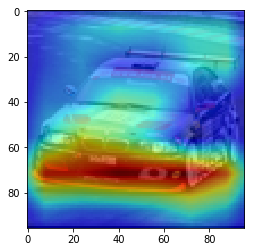

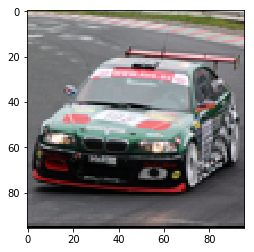

Predict : truck 	 Ans : truck


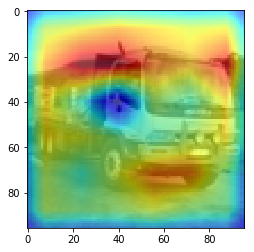

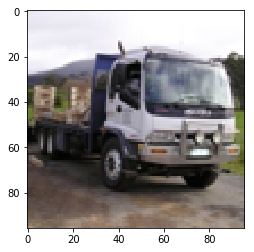

Predict : truck 	 Ans : truck


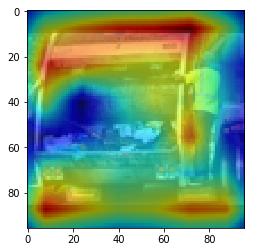

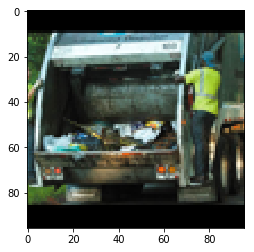

Predict : cat 	 Ans : cat


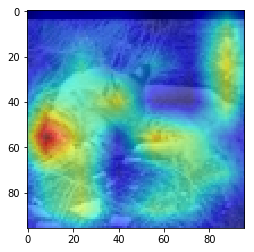

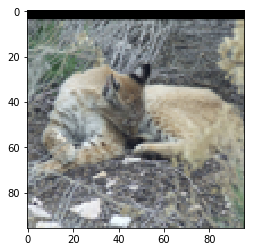

Predict : horse 	 Ans : deer


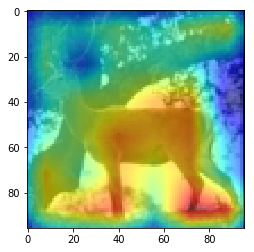

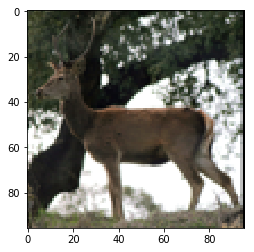

Predict : car 	 Ans : car


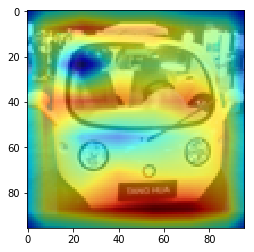

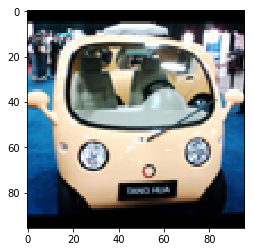

Predict : monkey 	 Ans : horse


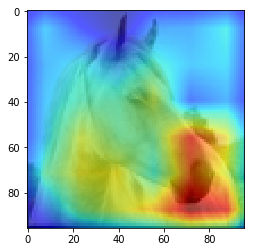

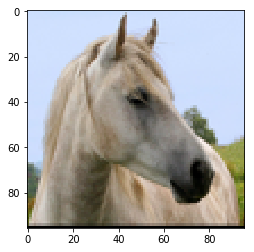

Predict : deer 	 Ans : truck


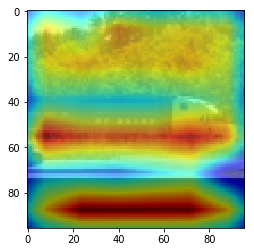

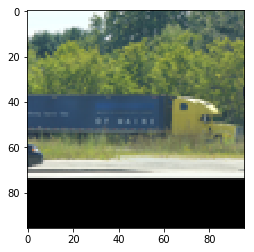

Predict : dog 	 Ans : deer


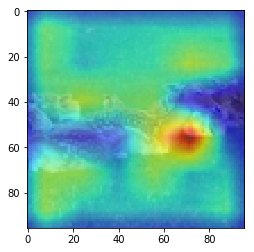

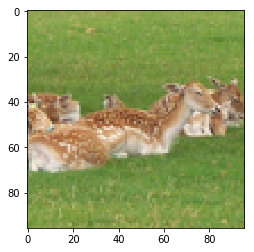

Predict : truck 	 Ans : truck


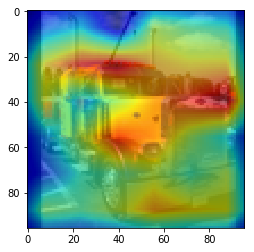

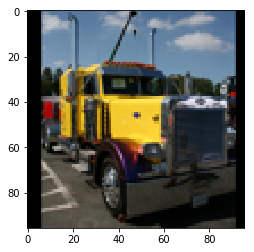

Predict : ship 	 Ans : ship


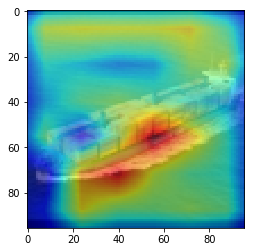

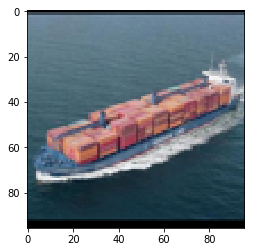

Predict : monkey 	 Ans : bird


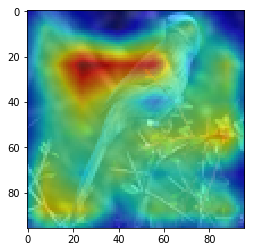

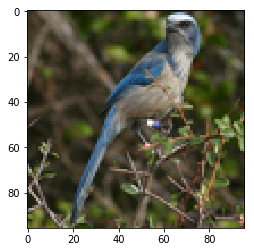

Predict : dog 	 Ans : horse


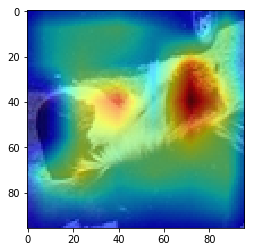

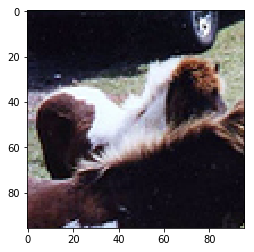

Predict : horse 	 Ans : horse


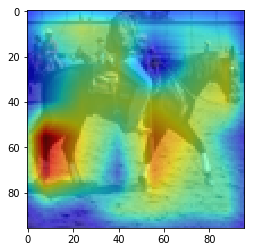

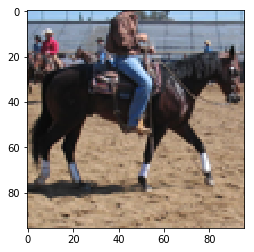

Predict : monkey 	 Ans : cat


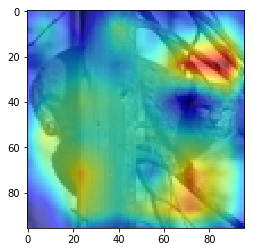

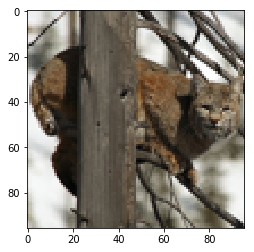

Predict : monkey 	 Ans : dog


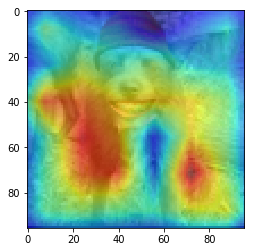

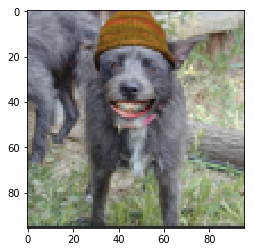

Predict : truck 	 Ans : truck


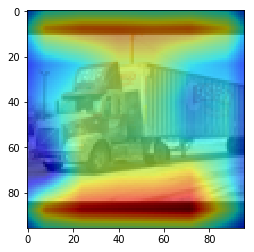

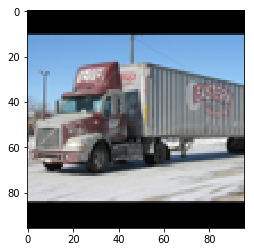

Predict : deer 	 Ans : deer


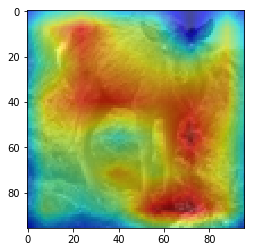

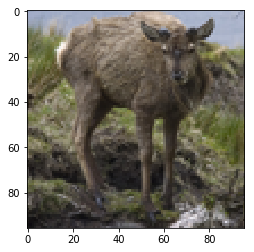

Predict : cat 	 Ans : cat


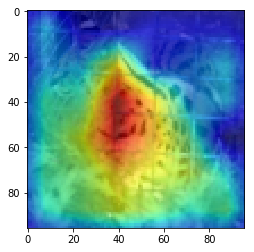

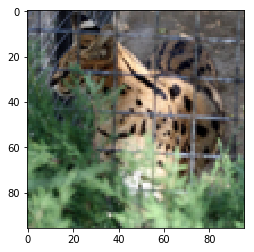

Predict : bird 	 Ans : bird


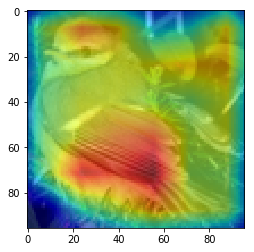

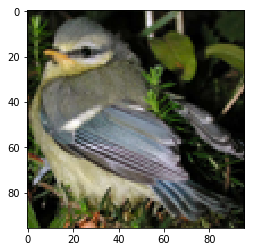

Predict : airplane 	 Ans : airplane


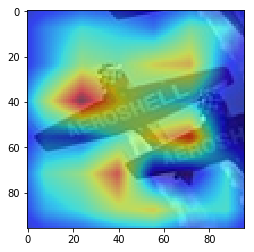

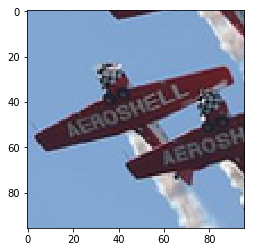

Predict : cat 	 Ans : deer


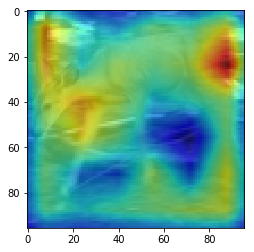

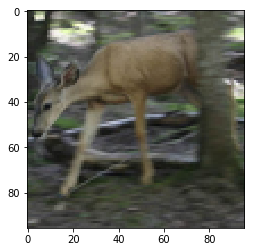

Predict : airplane 	 Ans : airplane


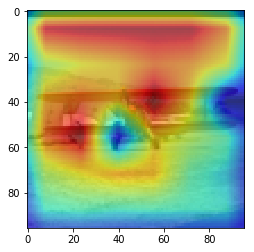

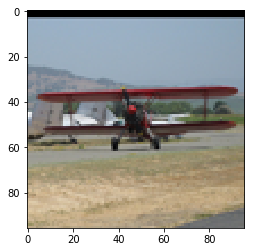

Predict : truck 	 Ans : truck


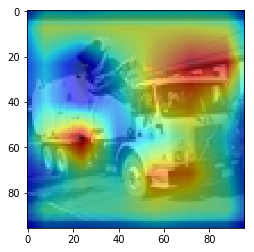

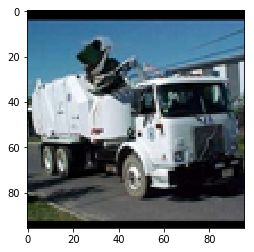

Predict : monkey 	 Ans : deer


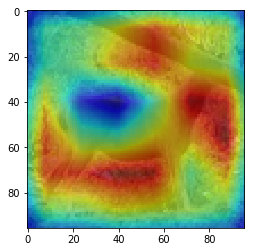

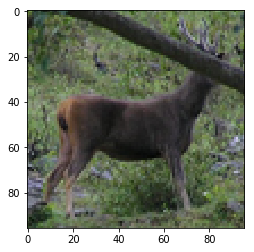

Predict : bird 	 Ans : bird


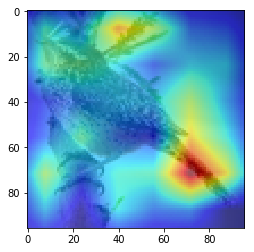

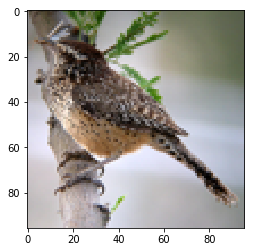

Predict : horse 	 Ans : horse


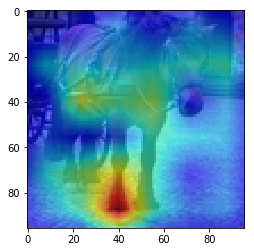

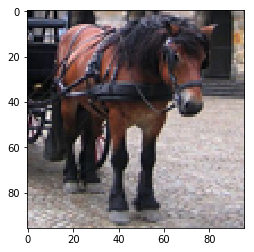

Predict : horse 	 Ans : monkey


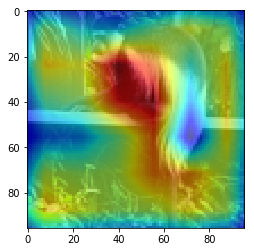

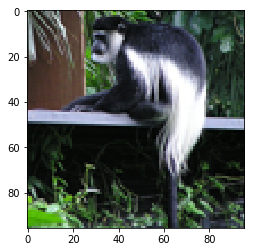

Predict : cat 	 Ans : monkey


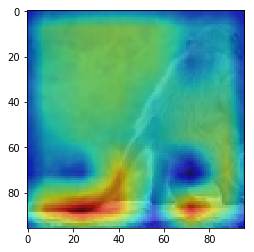

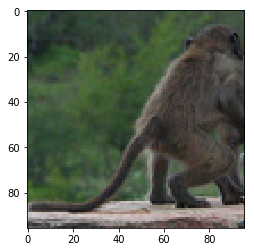

Predict : ship 	 Ans : ship


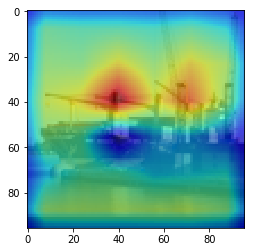

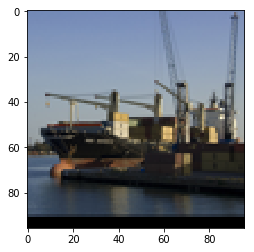

Predict : car 	 Ans : car


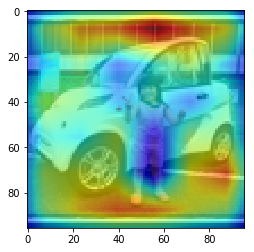

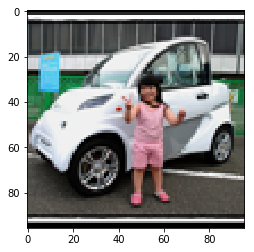

Predict : cat 	 Ans : cat


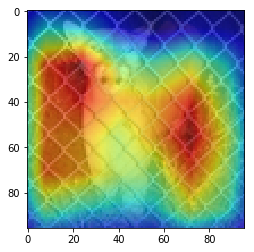

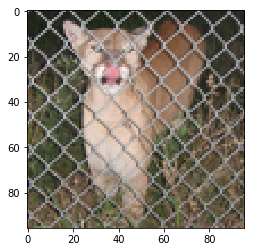

Predict : deer 	 Ans : deer


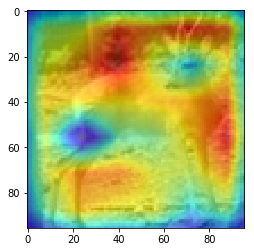

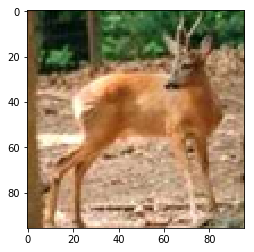

Predict : monkey 	 Ans : monkey


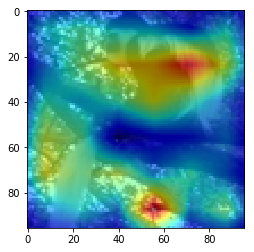

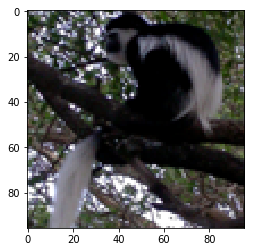

Predict : truck 	 Ans : truck


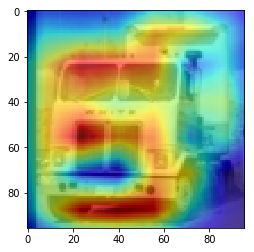

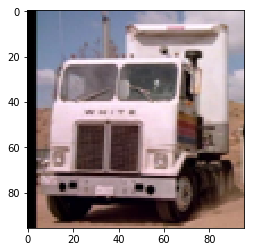

Predict : deer 	 Ans : deer


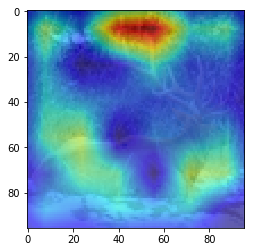

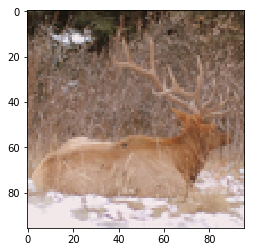

Predict : cat 	 Ans : dog


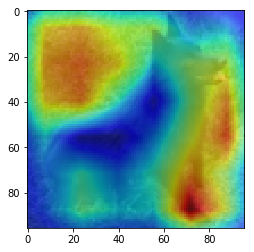

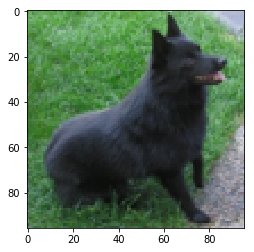

Predict : car 	 Ans : car


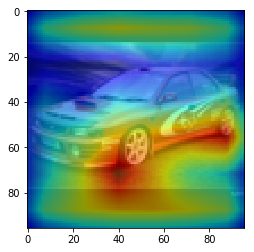

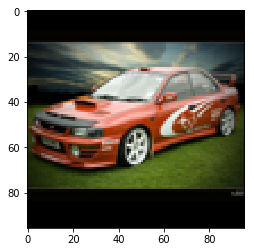

Predict : airplane 	 Ans : airplane


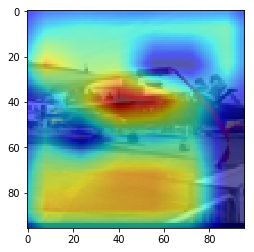

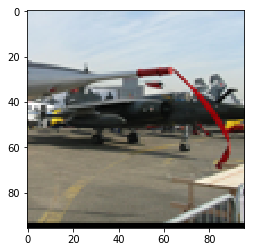

Predict : airplane 	 Ans : airplane


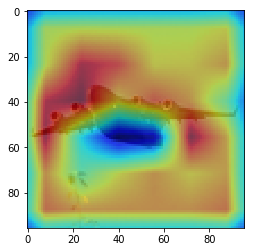

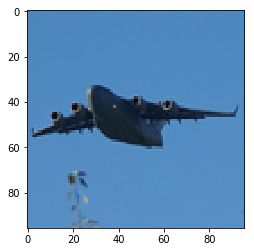

Predict : ship 	 Ans : ship


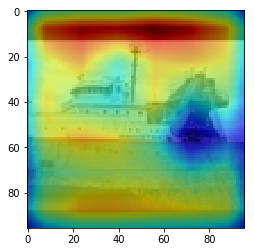

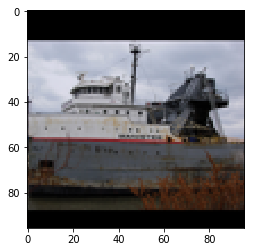

Predict : car 	 Ans : car


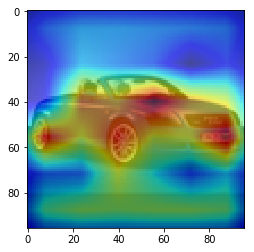

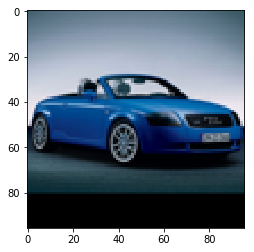

Predict : car 	 Ans : car


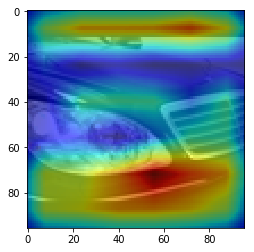

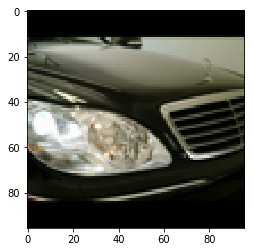

Predict : dog 	 Ans : monkey


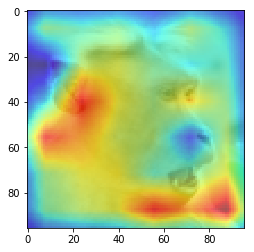

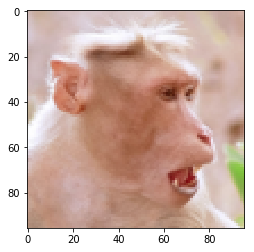

Predict : airplane 	 Ans : airplane


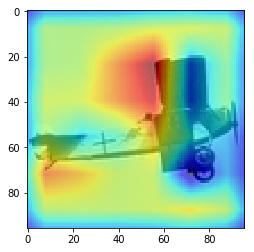

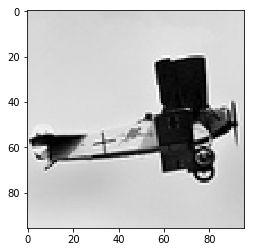

Predict : cat 	 Ans : cat


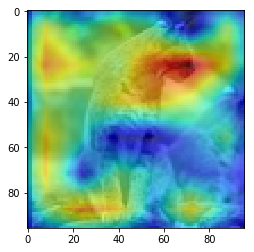

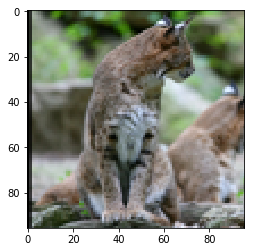

Predict : horse 	 Ans : horse


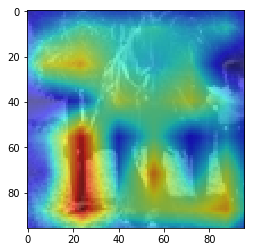

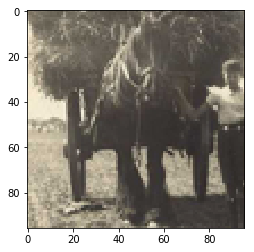

Predict : truck 	 Ans : truck


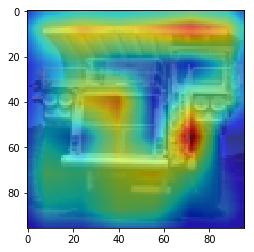

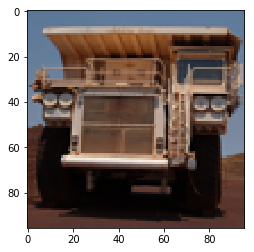

Predict : horse 	 Ans : horse


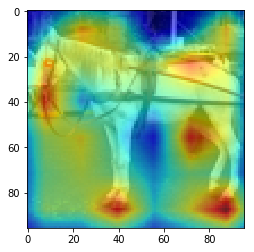

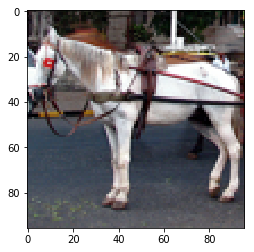

Predict : dog 	 Ans : deer


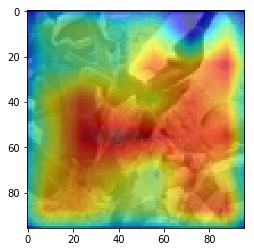

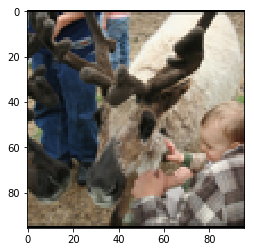

Predict : car 	 Ans : car


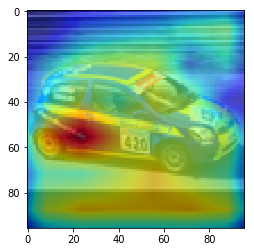

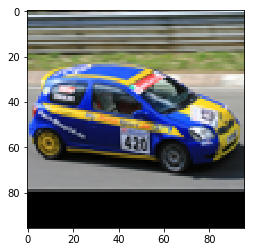

Predict : horse 	 Ans : horse


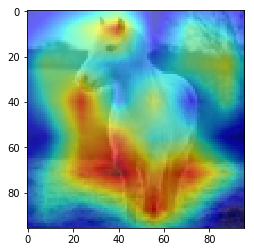

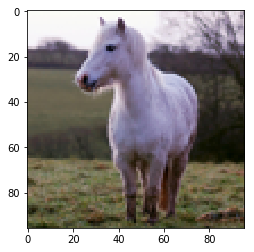

Predict : cat 	 Ans : bird


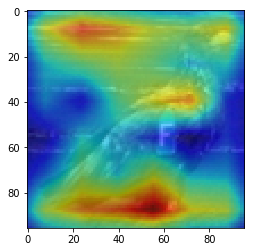

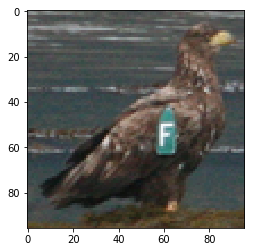

Predict : airplane 	 Ans : airplane


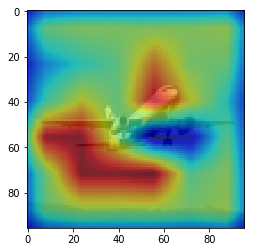

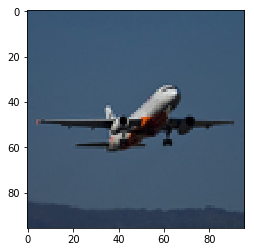

Predict : ship 	 Ans : truck


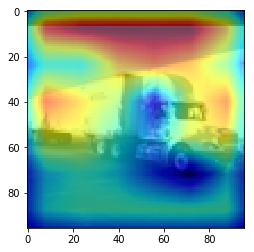

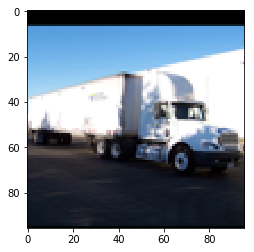

Predict : cat 	 Ans : cat


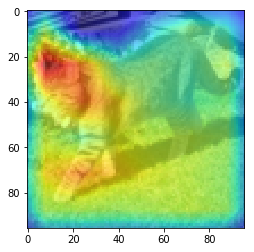

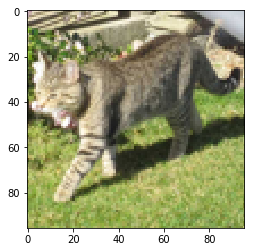

Predict : car 	 Ans : car


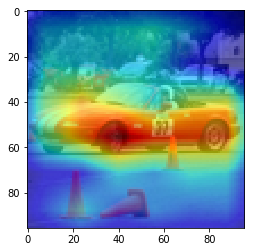

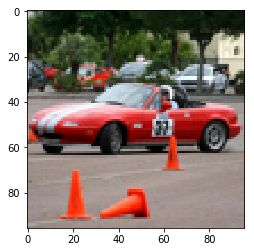

Predict : ship 	 Ans : ship


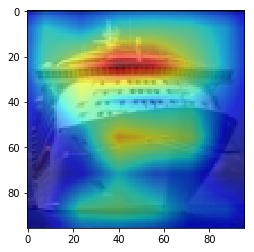

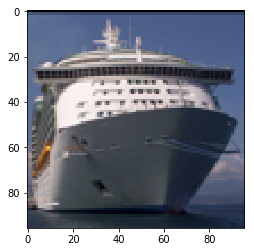

Predict : dog 	 Ans : dog


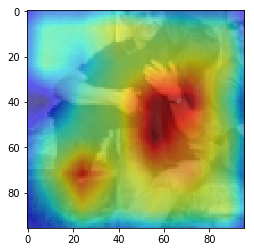

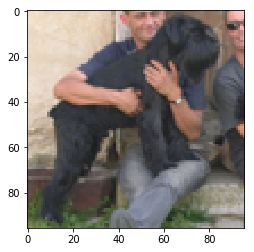

Predict : car 	 Ans : truck


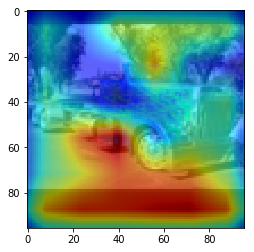

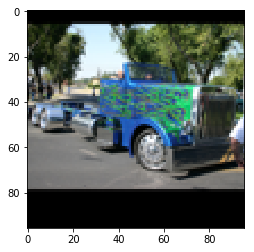

Predict : horse 	 Ans : horse


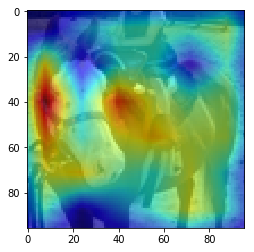

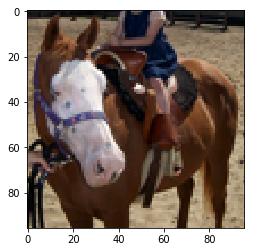

Predict : ship 	 Ans : ship


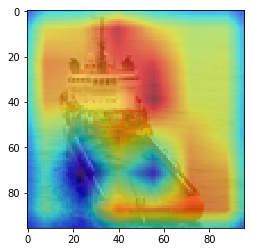

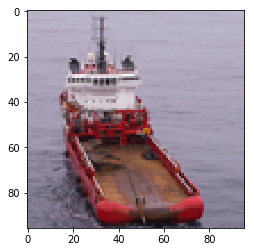

Predict : truck 	 Ans : ship


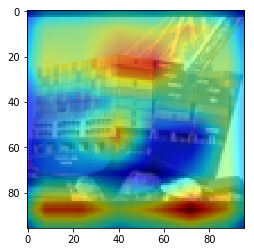

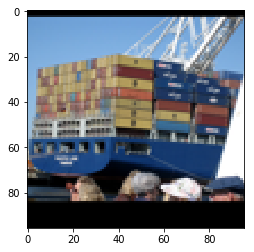

Predict : ship 	 Ans : ship


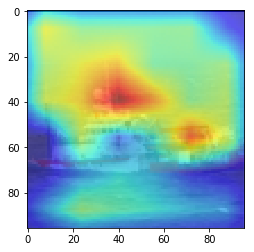

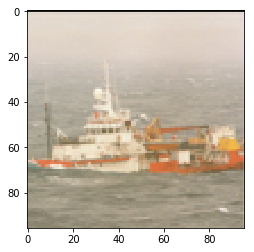

In [34]:
import skimage.transform

num = 0

for num in range(64):
    print("Predict :",classes[int(predicted[num])],"\t Ans :",classes[int(labels[num])])
    
    overlay = params[-2][int(predicted[num])].matmul(f[num].reshape(256,36)).reshape(6, 6).cpu().data.numpy()

    overlay = overlay - np.min(overlay)
    overlay = overlay / np.max(overlay)
    
    imshow(images[num].cpu())
    skimage.transform.resize(overlay, [96,96])
    plt.imshow(skimage.transform.resize(overlay, [96, 96]), alpha=0.6,cmap='jet')
    plt.show()
    imshow(images[num].cpu())
    plt.show()

In [27]:
print(params[-2].shape)
print(f.shape)

torch.Size([10, 256])
torch.Size([64, 256, 6, 6])


In [17]:
final_conv = 'conv'

#hook (원하는 위치의 gradient값)
feature_blobs = []
def hook_feature(module, input, output):
    feature_blobs.append(output.cpu().data.numpy())
    
model._modules.get(final_conv).register_forward_hook(hook_feature)

In [24]:
params = list(model.parameters())

weight_softmax = np.squeeze(params[-2].cpu().data.numpy())


def returnCAM(feature_conv, weight_softmax, class_idx):
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam.append(cv2.resize(cam_img, size_upsample))
    
    return output_cam

In [44]:
if not os.path.exists('./result'):
    os.mkdir('result/')

test_batch = iter(test_loader)

In [102]:
image_tensor, image_label = test_batch.next()
image_PIL = transforms.ToPILImage()(image_tensor[0])
image_PIL.save('./result/test.jpg')

image_tensor = Variable(image_tensor).cuda()
logit, _ = model(image_tensor)
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
print(idx[0].item(), classes[idx[0]], probs[0].item())
CAMs = returnCAM(feature_blobs[0], weight_softmax, [idx[0].item()])

8 ship 0.998473584651947


In [103]:
img = cv2.imread('result/test.jpg')
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0], (width, height)), cv2.COLORMAP_JET)
result = heatmap * 1 + img * 0
cv2.imwrite('result/CAM.jpg', result)

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 32, 32)


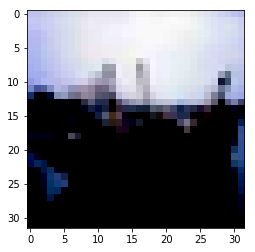

In [104]:
img = image_tensor.cpu().numpy().squeeze()
print(img.shape)
plt.imshow(np.transpose(img, (1, 2, 0)))

In [80]:
feature_blobs[0].shape

(1, 10, 8, 8)